### integration to fastai v1

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
torch.__version__

'1.0.0.dev20181028'

In [5]:
path = Path("../DATA/airbus-ship/")

In [6]:
(path/"segmentation").ls()

[PosixPath('../DATA/airbus-ship/segmentation/test_segmentation.csv'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks'),
 PosixPath('../DATA/airbus-ship/segmentation/trn_segmentation.csv'),
 PosixPath('../DATA/airbus-ship/segmentation/test_masks')]

In [7]:
(path/"segmentation/train_masks").ls()[:5]

[PosixPath('../DATA/airbus-ship/segmentation/train_masks/fdbe68f70.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/98f735813.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/9ff607cbe.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/d987e64df.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/f708bcc5d.jpg.npy')]

In [8]:
(path/"segmentation/train_masks").ls()[:5]

[PosixPath('../DATA/airbus-ship/segmentation/train_masks/fdbe68f70.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/98f735813.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/9ff607cbe.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/d987e64df.jpg.npy'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks/f708bcc5d.jpg.npy')]

In [9]:
train_seg_lbs = pd.read_csv(path/"segmentation/trn_segmentation.csv")
test_seg_lbs = pd.read_csv(path/"segmentation/test_segmentation.csv")

In [10]:
unique_img_ids = train_seg_lbs.ImageId.unique()
trn_fnames, val_fnames = train_test_split(unique_img_ids, test_size=0.1, random_state=42)

In [11]:
test_fnames = test_seg_lbs.ImageId.unique()

In [12]:
TRN_X = [f"train/{fname}" for fname in trn_fnames]
TRN_Y = [f"segmentation/train_masks/{fname}.npy" for fname in trn_fnames]

VAL_X = [f"train/{fname}" for fname in val_fnames]
VAL_Y = [f"segmentation/train_masks/{fname}.npy" for fname in val_fnames]

TEST_X = [f"test/{fname}" for fname in test_fnames]
TEST_Y = [f"segmentation/test_masks/{fname}.npy" for fname in test_fnames]

In [13]:
test_sub_fnames = list((path/"test_v2").glob("*.jpg"))

In [14]:
TEST_SUB_X = [f"test_v2/{fname.name}" for fname in test_sub_fnames]

In [15]:
len(TRN_X), len(VAL_X), len(TEST_X), len(TEST_SUB_X)

(34356, 3818, 4382, 15606)

In [16]:
path

PosixPath('../DATA/airbus-ship')

### Data

In [17]:
class DatasetBase(Dataset):
    "Base class for all fastai datasets."
    def __init__(self, c:int): self.c,self.item = c,None
    def __len__(self): return len(getattr(self, 'x', [1]))
    def set_item(self,item): self.item = item
    def clear_item(self): self.item = None
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

    @abstractmethod
    def _get_x(self,i): pass
    @abstractmethod
    def _get_y(self,i): pass

    def __getitem__(self, i):
        if self.item is None: return self._get_x(i),self._get_y(i)
        else: return self.item,0

In [18]:
class ImageSegment(Image):
    "Support applying transforms to segmentation masks data in `px`."
    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image': return self

    def refresh(self):
        self.sample_kwargs['mode'] = 'bilinear'
        return super().refresh()

    @property
    def data(self)->TensorImage:
        "Return this image pixels as a `LongTensor`."
        return self.px.long()

    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
        cmap:str='tab20', alpha:float=0.5, **kwargs):
        ax = show_image(self, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize, alpha=alpha)
        if title: ax.set_title(title)

In [19]:
class SegmentationDataset(DatasetBase):
    "A dataset for segmentation task."
    def __init__(self, path:PathOrStr, x:FilePathList, y:FilePathList, classes:Collection[Any]):
        assert len(x)==len(y)
        super().__init__(c=None)
        self.x, self.y = np.array(x),np.array(y)
        self.classes = classes
        self.path = path
    
    def _get_x(self, i):
        return open_image(self.path/self.x[i])
        
    def _get_y(self, i):    
        return ImageSegment(torch.from_numpy(np.load(self.path/self.y[i])).float()[None,:])

In [20]:
class ImageDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, ds_tfms:Optional[TfmList]=None,
                     num_workers:int=defaults.cpus, tfms:Optional[Collection[Callable]]=None, device:torch.device=None,
                     collate_fn:Callable=data_collate, size:int=None, **kwargs)->'ImageDataBunch':
        "Factory method. `bs` batch size, `ds_tfms` for `Dataset`, `tfms` for `DataLoader`."
        datasets = [train_ds,valid_ds]
        if test_ds is not None: datasets.append(test_ds)
        if ds_tfms: datasets = transform_datasets(*datasets, tfms=ds_tfms, size=size, **kwargs)
        dls = [DataLoader(*o, num_workers=num_workers) for o in
               zip(datasets, (bs,bs,bs), (True,False,False))]
        return cls(*dls, path=path, device=device, tfms=tfms, collate_fn=collate_fn)


In [21]:
trn_ds = SegmentationDataset(path, x=TEST_X, y=TEST_Y, classes=['ship'])
val_ds = SegmentationDataset(path, x=VAL_X, y=VAL_Y , classes=['ship'])
test_ds = SegmentationDataset(path, x=TEST_X, y=TEST_Y, classes=['ship'])

In [22]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is

In [23]:
data = ImageDataBunch.create(train_ds=trn_ds,
                             valid_ds=val_ds,
                             test_ds=test_ds,
                             path=path,
                             bs=8, num_workers=8, size=768,
                             do_crop=True,
                             ds_tfms=get_transforms(), tfm_y=True,
                             stats=imagenet_stats)

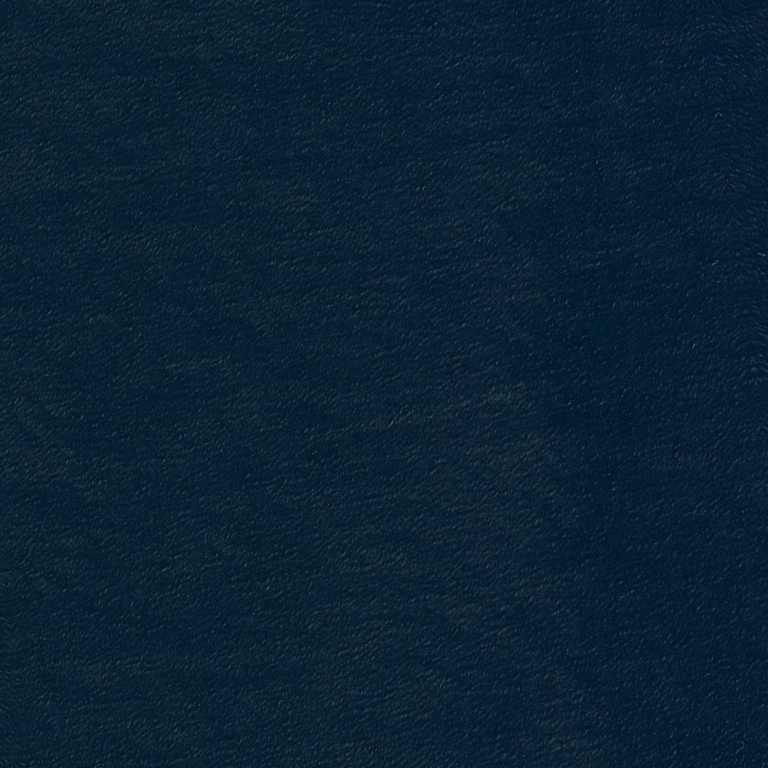

In [24]:
data.train_ds[1][0]

### Loss & Metric

In [25]:
def dice_loss(logits, target):
    logits = torch.sigmoid(logits)
    smooth = 1.0
    iflat = logits.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [26]:
def seg_loss(preds, targs):
    targs = targs.float()
    bce = F.binary_cross_entropy_with_logits(preds, targs)
    dice = dice_loss(preds, targs)
    return 20 * bce + dice

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, logits, target):
        if not (target.size() == logits.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), logits.size()))

        max_val = (-logits).clamp(min=0)
        loss = logits - logits * target + max_val + \
            ((-max_val).exp() + (-logits - max_val).exp()).log()

        invprobs = F.logsigmoid(-logits * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [28]:
class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        targets = targets.float()
        logits = F.sigmoid(logits)
        return F.binary_cross_entropy(logits, targets)

In [29]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        target = target.float()
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [30]:
sys.path.append("../airbus/")
from skimage.measure import label
from eval_metric import sigmoid, get_gt_masks, create_iou_matrix, f2_IOU, get_pred_masks

In [31]:
def single_image_score(labels, gt_rles, gt):
    """
    return avg thresholded f2 score for single image
    labels : labeled image array
    gt_rles : array of rles
    """
    if len(np.unique(labels)) == 1:
        if gt is None: 
            """original image has no instance"""
            return 1
        else:
            """no prediction is made tp = 0"""
            return 0
    else:
        pred_mask_arrays = get_pred_masks(labels)
        gt_mask_arrays = get_gt_masks(gt_rles)
        IOU = create_iou_matrix(pred_mask_arrays, gt_mask_arrays)
        return f2_IOU(IOU)

### Training

In [32]:
loss_fn = MixedLoss(10, 2)

In [33]:
data.c = 1

In [34]:
learn = Learner.create_unet(data, models.resnet18, loss_func=loss_fn)

In [35]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [36]:
shift = 0 # shift to keep track of file index 
n_valids = len(learn.data.valid_ds) # total # of validation samples
fnames = [fname.split("/")[1] for fname in learn.data.valid_ds.ds.x] # validation filenames
df = train_seg_lbs

def fastai_metric(preds, targs):
    global shift
    global df
    global fnames
    global n_valids
    
    mask_thresh = 0.5 
    n_x = len(preds)

    scores = [] 
    preds = (sigmoid(to_np(preds).squeeze(1)) > mask_thresh).astype('uint8')
    gts = to_np(targs.squeeze(1))
    
    for i, (gt_i, pred_i) in enumerate(zip(gts, preds)):
        fname = fnames[i+shift]
        gt_rles = df[df.ImageId == fname.split("/")[-1]]['EncodedPixels'].values
        labels = label(pred_i)
        scores.append(single_image_score(labels, gt_rles, gt_i))

    shift += n_x
    if shift == n_valids: shift = 0
    return torch.tensor(np.mean(scores))

In [37]:
learn.metrics = [fastai_metric]

In [38]:
len(learn.layer_groups)

3

In [39]:
learn.load("resnet_18_fastai_v1")

In [40]:
learn.unfreeze()

In [43]:
lr_find(learn, 1e-10, 1e-2)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


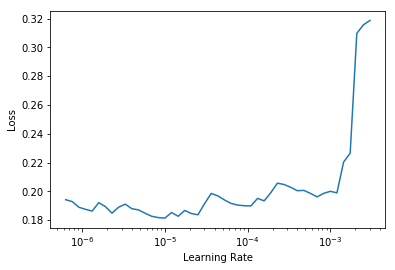

In [42]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, max_lr=5e-5)

epoch,train_loss,valid_loss,fastai_metric
1,0.200585,0.226394,0.340957
2,0.215887,4.258292,0.335905
3,0.215707,0.235869,0.332708
4,0.222278,3.162422,0.338375


### Small Object Model

In [48]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, d, stride=1, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, dilation=d, padding=pad, bias=True)
        #self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv(x))
        return x

In [49]:
class SmallObjectModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Front 
        self.conv1 = ConvBlock(ni=3, no=64, ks=3, d=1)
        self.conv2 = ConvBlock(ni=64, no=64, ks=3, d=1)

        self.conv3 = ConvBlock(ni=64, no=128, ks=3, d=2)
        self.conv4 = ConvBlock(ni=128, no=128, ks=3, d=2)

        self.conv5 = ConvBlock(ni=128, no=256, ks=3, d=3)
        self.conv6 = ConvBlock(ni=256, no=256, ks=3, d=3)
        self.conv7 = ConvBlock(ni=256, no=256, ks=3, d=3)

        # LFE
        self.conv8 = ConvBlock(ni=256, no=256, ks=3, d=3)
        self.conv9 = ConvBlock(ni=256, no=256, ks=3, d=3)
        self.conv10 = ConvBlock(ni=256, no=256, ks=3, d=3)
        self.conv11 = ConvBlock(ni=256, no=256, ks=3, d=2)
        self.conv12 = ConvBlock(ni=256, no=256, ks=3, d=2)
        self.conv13 = ConvBlock(ni=256, no=256, ks=3, d=1)
        self.conv14 = ConvBlock(ni=256, no=256, ks=3, d=1)

        # Head
        self.conv15 = ConvBlock(ni=256, no=1024, ks=7, d=3)
        self.conv16 = ConvBlock(ni=1024, no=1024, ks=1, d=1)
        self.conv17 = ConvBlock(ni=1024, no=1, ks=1, d=1)
        
    def forward(self, x):
        out_sz = x.shape[-2:]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)
        x = self.conv17(x)
        x = F.interpolate(x, out_sz, mode='nearest')
        return x

In [50]:
model = SmallObjectModel().cuda()

In [51]:
x = torch.ones((1,3,192,192)).cuda()

In [52]:
x.shape

torch.Size([1, 3, 192, 192])

In [53]:
out = model(x)

In [54]:
out.shape

torch.Size([1, 1, 192, 192])

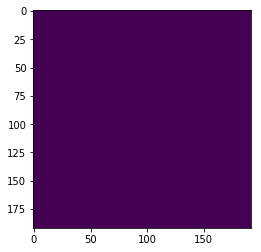

In [55]:
plt.imshow(to_np(out)[0,0])